In [120]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import a_funciones as fn 
import joblib
import matplotlib as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree ###para ajustar arboles de decisión
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, f1_score, classification_report

In [121]:
#Se vuelve a llamar la base de datos para la seleccion de variables
data = pd.read_csv("https://raw.githubusercontent.com/jsebastianzm/HR_T1_Analitica/main/data/data_preprocesamiento.csv")

In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   BusinessTravel           4410 non-null   object 
 2   Department               4410 non-null   object 
 3   DistanceFromHome         4410 non-null   float64
 4   Education                4410 non-null   int64  
 5   EducationField           4410 non-null   object 
 6   EmployeeID               4410 non-null   int64  
 7   Gender                   4410 non-null   object 
 8   JobLevel                 4410 non-null   int64  
 9   JobRole                  4410 non-null   object 
 10  MaritalStatus            4410 non-null   object 
 11  MonthlyIncome            4410 non-null   float64
 12  NumCompaniesWorked       4410 non-null   int64  
 13  PercentSalaryHike        4410 non-null   int64  
 14  StockOptionLevel        

In [123]:
#Es necesario volver a asignar las variables como variables object ya que al crearse el dataframe y volver
# a leerse con la libreria pandas, las variables vuelven a cambiar de tipo.
columns_category = ['EmployeeID']
data[columns_category] = data[columns_category].astype(object)
data.drop(['EmployeeID'], axis = 1, inplace = True)

In [124]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   BusinessTravel           4410 non-null   object 
 2   Department               4410 non-null   object 
 3   DistanceFromHome         4410 non-null   float64
 4   Education                4410 non-null   int64  
 5   EducationField           4410 non-null   object 
 6   Gender                   4410 non-null   object 
 7   JobLevel                 4410 non-null   int64  
 8   JobRole                  4410 non-null   object 
 9   MaritalStatus            4410 non-null   object 
 10  MonthlyIncome            4410 non-null   float64
 11  NumCompaniesWorked       4410 non-null   int64  
 12  PercentSalaryHike        4410 non-null   int64  
 13  StockOptionLevel         4410 non-null   int64  
 14  TotalWorkingYears       

In [125]:
#Se separan las bases de datos en la variable a predecir y las variables independientes
y = data["Attrition"]
x = data.loc[:, ~data.columns.isin(['Attrition'])]
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   BusinessTravel           4410 non-null   object 
 2   Department               4410 non-null   object 
 3   DistanceFromHome         4410 non-null   float64
 4   Education                4410 non-null   int64  
 5   EducationField           4410 non-null   object 
 6   Gender                   4410 non-null   object 
 7   JobLevel                 4410 non-null   int64  
 8   JobRole                  4410 non-null   object 
 9   MaritalStatus            4410 non-null   object 
 10  MonthlyIncome            4410 non-null   float64
 11  NumCompaniesWorked       4410 non-null   int64  
 12  PercentSalaryHike        4410 non-null   int64  
 13  StockOptionLevel         4410 non-null   int64  
 14  TotalWorkingYears       

In [126]:
#Se asignan las variables object a variables dummies
# #COLUMNAS NUMERICAS DUMMIES
data_dummies = x.select_dtypes(include=['object'])
data_dummies.columns
x = pd.get_dummies(x, columns=data_dummies.columns)

In [127]:
#Se aplica labelencoder a la variables Y
encoder = LabelEncoder()

# Ajustar y transformar las categorías
y = encoder.fit_transform(y)
y = pd.DataFrame(y, columns = ['Attrition'])
y.head()



,Attrition
0,0
1,1
2,0
3,0
4,0


In [128]:
scaler=StandardScaler()
scaler.fit(x)
X2=scaler.transform(x)
X=pd.DataFrame(X2,columns=x.columns)


In [278]:
m_lreg = LogisticRegression()
m_rtree= tree.DecisionTreeClassifier()
m_rf= RandomForestClassifier()
m_gbt=GradientBoostingClassifier()

modelos=list([m_lreg,m_rtree, m_rf, m_gbt])
# modelos=list([m_lreg,m_rtree])



In [279]:
#
var_names_models=fn.sel_variables(modelos,X,y,threshold="1.3*mean")
var_names_models.shape


(19,)

In [280]:
#Se aplica seleccion de variables con el metodo Lasso
var_names_lasso=fn.sel_variablesLasso(modelos,X,y,alpha=0.03,max_features=15)
var_names_lasso.shape

(8,)

In [281]:
X_mod=X[var_names_models] ### matriz con variables seleccionadas
print(X_mod.shape, X.shape)

(4410, 19) (4410, 44)


In [282]:
X_Lasso=X[var_names_lasso] ### matriz con variables seleccionadas
print(X_Lasso.shape, X.shape)

(4410, 8) (4410, 44)


In [283]:
# X_mod.head()

In [284]:
#Medicion de los modelos para la clasificacion
F1_df=fn.medir_modelos(modelos,"accuracy",X,y,10) ## base con todas las variables 
F1_mod=fn.medir_modelos(modelos,"accuracy",X_mod,y,10) ### base con variables seleccionadas
F1_Lasso=fn.medir_modelos(modelos,"accuracy",X_Lasso,y,10) ### base con variables seleccionadas

## Toca agregar y completar el boxplot siguiente

<Axes: >

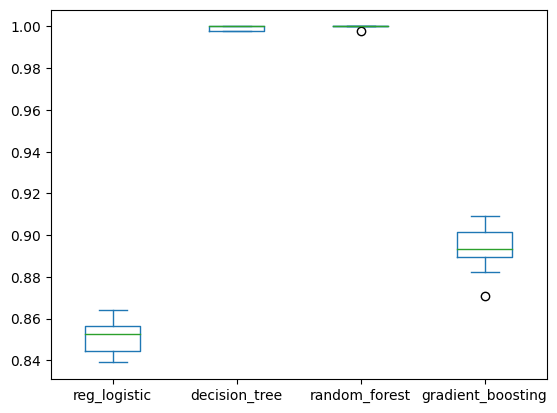

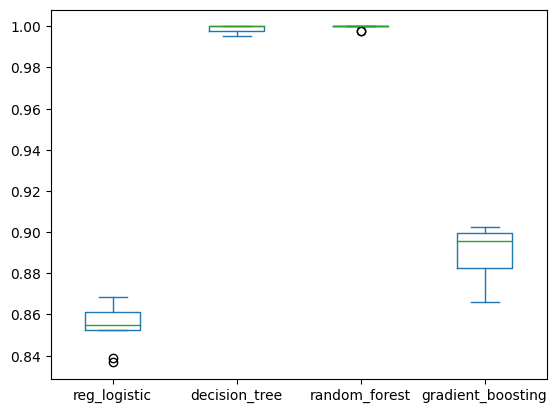

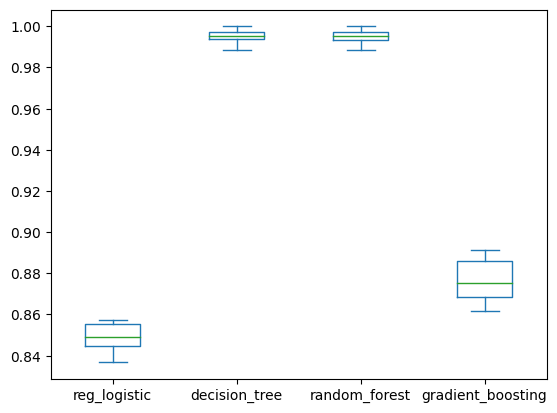

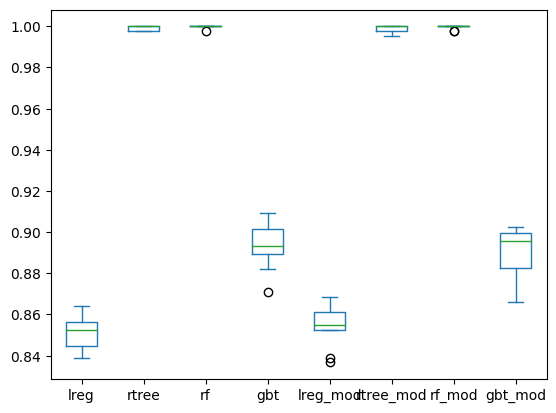

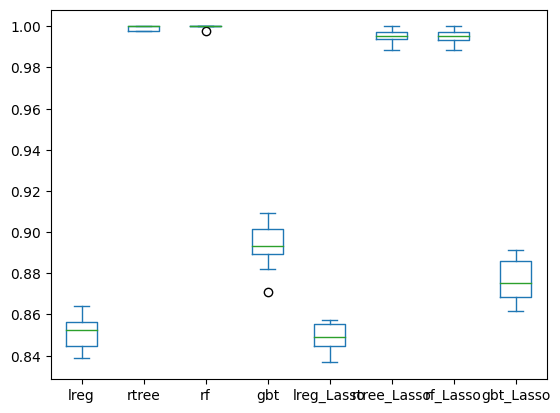

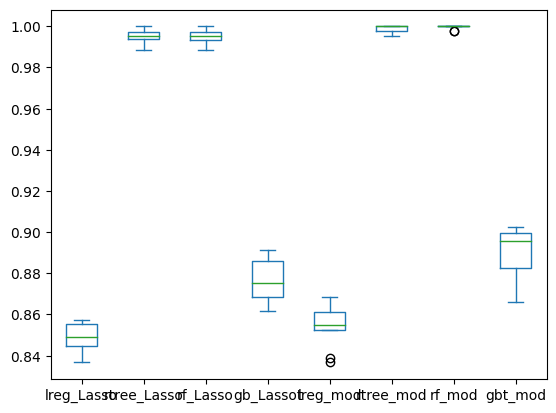

In [285]:
F1_score1 =pd.concat([F1_df,F1_mod],axis=1)
F1_score1.columns=['lreg', 'rtree', 'rf', 'gbt',
    'lreg_mod', 'rtree_mod', 'rf_mod', 'gbt_mod']

F1_score2 =pd.concat([F1_df,F1_Lasso],axis=1)
F1_score2.columns=['lreg', 'rtree', 'rf', 'gbt',
    'lreg_Lasso', 'rtree_Lasso', 'rf_Lasso', 'gbt_Lasso']

F1_score3 =pd.concat([F1_Lasso,F1_mod],axis=1)
F1_score3.columns=['lreg_Lasso', 'rtree_Lasso', 'rf_Lasso', 'gb_Lassot',
    'lreg_mod', 'rtree_mod', 'rf_mod', 'gbt_mod']

F1_df.plot(kind='box') #### gráfico para modelos todas las varibles
F1_mod.plot(kind='box') ### gráfico para modelo variables seleccionadas
F1_Lasso.plot(kind='box') ### gráfico para modelos sel y todas las variables
F1_score1.plot(kind='box')
F1_score2.plot(kind='box')
F1_score3.plot(kind='box')

In [286]:
F1_df.mean()

reg_logistic         0.851474
decision_tree        0.999093
random_forest        0.999773
gradient_boosting    0.893197
dtype: float64

In [287]:
F1_mod.mean()

reg_logistic         0.854422
decision_tree        0.998866
random_forest        0.999546
gradient_boosting    0.890249
dtype: float64

In [288]:
F1_Lasso.mean()

reg_logistic         0.848526
decision_tree        0.995238
random_forest        0.995011
gradient_boosting    0.876644
dtype: float64

In [363]:
# Separación en conjuntos de entrenamiento y validación con 80% de muestras para entrenamiento
x_train, x_test, y_train, y_test = train_test_split(X_mod, y, test_size=0.2, random_state=1)

In [364]:
param_grid = {'max_depth': [10,50,100,200],# Maxima profundidad
              'max_features': [5,10,30,50],# Maximo de caracteristicas a usar
              'min_samples_leaf': [1,2,3,4,5,7],#Minimo de muestras para los nodos hoja
              'criterion': ['gini', 'entropy']}#Medir la cantidad de división.

In [365]:
grid_search = GridSearchCV(m_rtree, param_grid, scoring='recall', cv=10)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 50, 100, 200],
                         'max_features': [5, 10, 30, 50],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 7]},
             scoring='recall')

In [366]:
resultados = grid_search.cv_results_

In [367]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 200,
 'max_features': 10,
 'min_samples_leaf': 1}

In [368]:
pd.set_option('display.max_colwidth', 100)
pd_resultados = pd.DataFrame(resultados)
pd_resultados[["params","mean_test_score"]].sort_values(by="mean_test_score", ascending=False).head()

,params,mean_test_score
78,"{'criterion': 'gini', 'max_depth': 200, 'max_features': 10, 'min_samples_leaf': 1}",0.936195
24,"{'criterion': 'gini', 'max_depth': 50, 'max_features': 5, 'min_samples_leaf': 1}",0.934444
48,"{'criterion': 'gini', 'max_depth': 100, 'max_features': 5, 'min_samples_leaf': 1}",0.934377
174,"{'criterion': 'entropy', 'max_depth': 200, 'max_features': 10, 'min_samples_leaf': 1}",0.934377
120,"{'criterion': 'entropy', 'max_depth': 50, 'max_features': 5, 'min_samples_leaf': 1}",0.930774


In [369]:
decision_tree_final=grid_search.best_estimator_ ### Guardar el modelo con hyperparameter tunning

In [379]:
joblib.dump(decision_tree_final, "decision_tree_final.pkl") ## Modelo escogido
joblib.dump(columns_category, "list_cat.pkl") ### para realizar imputacion
joblib.dump(data_dummies, "list_dummies.pkl")  ### para convertir a dummies
joblib.dump(X_mod, "var_names.pkl")  ### para variables con que se entrena modelo
joblib.dump(scaler, "scaler.pkl") ##

['scaler.pkl']

In [371]:
decision_tree_final = joblib.load("decision_tree_final.pkl")
list_cat=joblib.load("list_cat.pkl")
list_dummies=joblib.load("list_dummies.pkl")
var_names=joblib.load("var_names.pkl")
scaler=joblib.load("scaler.pkl") 

In [372]:
# eval=cross_validate(decision_tree_final,X_mod,y,cv=5,scoring="f1",return_train_score=True)

In [373]:
decision_tree_final.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=200, max_features=10)

In [374]:
print ("Train - Accuracy :", metrics.accuracy_score(y_train, decision_tree_final.predict(x_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, decision_tree_final.predict(x_train)))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, decision_tree_final.predict(x_test)))
print ("Test - classification report :", metrics.classification_report(y_test, decision_tree_final.predict(x_test)))

Train - Accuracy : 1.0
Train - classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2979
           1       1.00      1.00      1.00       549

    accuracy                           1.00      3528
   macro avg       1.00      1.00      1.00      3528
weighted avg       1.00      1.00      1.00      3528

Test - Accuracy : 0.9897959183673469
Test - classification report :               precision    recall  f1-score   support

           0       0.99      0.99      0.99       720
           1       0.97      0.98      0.97       162

    accuracy                           0.99       882
   macro avg       0.98      0.98      0.98       882
weighted avg       0.99      0.99      0.99       882



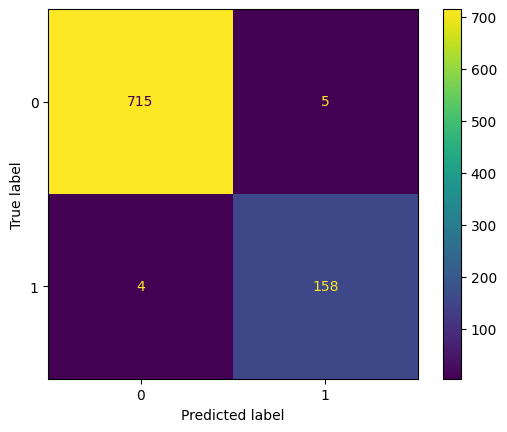

In [375]:
# Matriz de confusion
cm1= confusion_matrix(y_test, decision_tree_final.predict(x_test))
# Visualización de la matriz de confusion
cm1_display = ConfusionMatrixDisplay(confusion_matrix = cm1)
cm1_display.plot()

In [376]:
##### Mirar importancia de variables para tomar acciones ###
columnas=pd.DataFrame(X_mod.columns).rename(columns={0:'columnas'})
importancia=pd.DataFrame(decision_tree_final.feature_importances_).rename(columns={0:'importancia'})
cf=pd.concat([columnas,importancia], axis=1).sort_values('importancia',ascending=False).head(7)

In [377]:
cf

,columnas,importancia
16,YearsAtCompany,0.124440
9,MonthlyIncome,0.114698
0,Age,0.108089
11,PercentSalaryHike,0.090792
14,TrainingTimesLastYear,0.070741
13,TotalWorkingYears,0.062525
10,NumCompaniesWorked,0.058730
